In [ ]:
!pip install torchtext==0.8.0

In [ ]:
import copy
from typing import Optional, Any
import numpy as np

import torch
import torch.nn as nn

from torch import Tensor
import torch.nn.functional as F

import math
import torch
import torch.nn as nn

class TransformerEncoderLayer(nn.Module):
    r"""TransformerEncoderLayer is made up of self-attn and feedforward network.
    This standard encoder layer is based on the paper "Attention Is All You Need".
    Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez,
    Lukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in
    Neural Information Processing Systems, pages 6000-6010. Users may modify or implement
    in a different way during application.
    Args:
        d_model: the number of expected features in the input (required).
        nhead: the number of heads in the multiheadattention models (required).
        dim_feedforward: the dimension of the feedforward network model (default=2048).
        dropout: the dropout value (default=0.1).
        activation: the activation function of intermediate layer, relu or gelu (default=relu).
    Examples::
        >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        >>> src = torch.rand(10, 32, 512)
        >>> out = encoder_layer(src)
    """

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, norm_type = 'before', activation = "relu"):
        super(TransformerEncoderLayer, self).__init__()
        self.norm_type = norm_type
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerEncoderLayer, self).__setstate__(state)

    def forward(self, src: Tensor, src_mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        r"""Pass the input through the encoder layer.
        Args:
            src: the sequence to the encoder layer (required).
            src_mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).
        Shape:
            see the docs in Transformer class.
        """
        if self.norm_type == 'after' : 
            src2 = self.self_attn(src, src, src, attn_mask=src_mask,
                                  key_padding_mask=src_key_padding_mask)[0]
            src = src + self.dropout1(src2)
            src = self.norm1(src)
            return src
        elif  self.norm_type == 'before':
            src2 = self.norm1(src)
            src2 = self.self_attn(src2, src2, src2, attn_mask=src_mask,
                                  key_padding_mask=src_key_padding_mask)[0]
            src = src + self.dropout1(src2)
            return src
        else :
            raise ValueError()

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5, norm_type = 'before'):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout, norm_type)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

def _get_activation_fn(activation):
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu
    else :
        raise ValueError()

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

Load and batch data
-------------------




In [ ]:
import io
import torch
from torchtext.utils import download_from_url, extract_archive
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

url = 'https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip'
test_filepath, valid_filepath, train_filepath = extract_archive(download_from_url(url))
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer,
                                      iter(io.open(train_filepath,
                                                   encoding="utf8"))))

def data_process(raw_text_iter):
  data = [torch.tensor([vocab[token] for token in tokenizer(item)],
                       dtype=torch.long) for item in raw_text_iter]
  return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

train_data = data_process(iter(io.open(train_filepath, encoding="utf8")))
val_data = data_process(iter(io.open(valid_filepath, encoding="utf8")))
test_data = data_process(iter(io.open(test_filepath, encoding="utf8")))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def batchify(data, bsz):
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 100
eval_batch_size = 10
train_data = batchify(train_data, batch_size)
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:00<00:00, 8.54MB/s]
36718lines [00:01, 28361.76lines/s]


In [ ]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 5 # learning rate



import time

def train():
    # record gradients
    gradients = []

    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        if data.size(0) != bptt:
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
        # record gradients
        gradients.append(np.linalg.norm(model.encoder.weight.grad.cpu()))
        print(np.linalg.norm(model.encoder.weight.grad.cpu()))
    return gradients

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            if data.size(0) != bptt:
                src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            output = eval_model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

Loop over epochs. Save the model if the validation loss is the best
we've seen so far. Adjust the learning rate after each epoch.



In [ ]:
dict_res = {}
for norm_type in ['after', 'before']:
    print(norm_type)
    dict_res[norm_type] = {}
    for nlayer in [50, 20, 10, 5, 1]:
        dict_res[norm_type][nlayer] = []

        ntokens = len(vocab.stoi) # the size of vocabulary
        emsize = 200 # embedding dimension
        nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
        nhead = 2 # the number of heads in the multiheadattention models
        dropout = 0.2 # the dropout value
        model = TransformerModel(ntokens, emsize, nhead, nhid, nlayer, dropout, norm_type = norm_type).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
        best_val_loss = float("inf")
        epochs = 1 # The number of epochs
        best_model = None
        gradients = []


        for epoch in range(1, epochs + 1):
            epoch_start_time = time.time()
            gradients += train()
            val_loss = evaluate(model, val_data)
            print('-' * 89)
            print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
                  'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                            val_loss, math.exp(val_loss)))
            print('-' * 89)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model

            scheduler.step()
        del model
        dict_res[norm_type][nlayer].append(np.mean(gradients))

after
0.10442476
0.029843576
0.06542082
0.0003126754
3.1704363e-05
2.1683087e-05
4.3661246e-05
5.6758663e-06
1.2230405e-05
2.2563963e-06
1.6722808e-05
7.251387e-06
6.646648e-06
2.3478722e-06
1.0202228e-05
6.2893264e-06
8.245571e-06
7.64677e-06
6.807437e-06
4.4786566e-06
5.678174e-06
7.249068e-05
1.4549523e-05
0.00016655042
1.8984207e-06
5.6564104e-06
1.8016375e-06
3.5556989e-06
5.208738e-06
1.7282592e-06
9.532341e-06
2.4507533e-06
1.398104e-06
5.2487353e-06
7.1489615e-07
2.9874816e-06
1.0002241e-06
3.7094783e-06
9.568337e-07
2.692368e-06
2.2604765e-06
5.737444e-07
3.5868331e-06
4.528114e-06
4.5426515e-07
3.544029e-06
9.668411e-07
3.4833633e-06
1.4927109e-06
8.486684e-07
2.8452837e-06
1.1380166e-06
2.8841657e-06
3.52286e-06
9.1499663e-07
3.0215676e-06
2.3150149e-06
1.313734e-06
3.123918e-06
1.7194842e-06
1.0915003e-06
2.5194877e-06
2.4506317e-06
2.668157e-06
7.2830215e-07
1.417945e-06
2.627596e-06
1.272716e-06
1.7751947e-06
2.8782583e-06
1.3939689e-06
3.7668437e-06
9.195289e-07
2.227558

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
5.2477985e-06
5.2367986e-06
8.859929e-06
2.1153596e-06
4.3197847e-06
4.278165e-06
5.156968e-06
5.0469134e-06
5.5591604e-06
4.2845904e-06
4.0407085e-06
1.4750235e-06
4.8469506e-06
4.5765155e-06
2.6174137e-06
4.7821836e-06
4.242211e-06
3.9726656e-06
4.799474e-06
4.9728815e-06
4.1124654e-06
2.7879657e-06
6.147805e-06
5.086792e-06
2.7079213e-06
5.0763056e-06
3.8179132e-06
3.9903e-06
4.443683e-06
4.182944e-06
4.2113443e-06
3.7568036e-06
4.9267105e-06
7.1447494e-06
2.1651415e-06
4.0331056e-06
5.544773e-06
6.548309e-06
3.7500643e-06
4.3428486e-06
2.3314494e-06
5.3655554e-06
3.666511e-06
5.3773038e-06
5.7544576e-06
2.2069437e-06
4.080941e-06
3.2327728e-06
4.8212974e-06
4.53243e-06
2.1842516e-06
4.399672e-06
3.0429676e-06
4.843719e-06
3.95052e-06
5.3700583e-06
1.9974204e-06
3.8529406e-06
4.672426e-06
4.43087e-06
3.587256e-06
4.264454e-06
4.6868117e-06
5.0816348e-06
3.8289318e-06
2.9435746e-06
4.5890065e-06
4.9565224e-

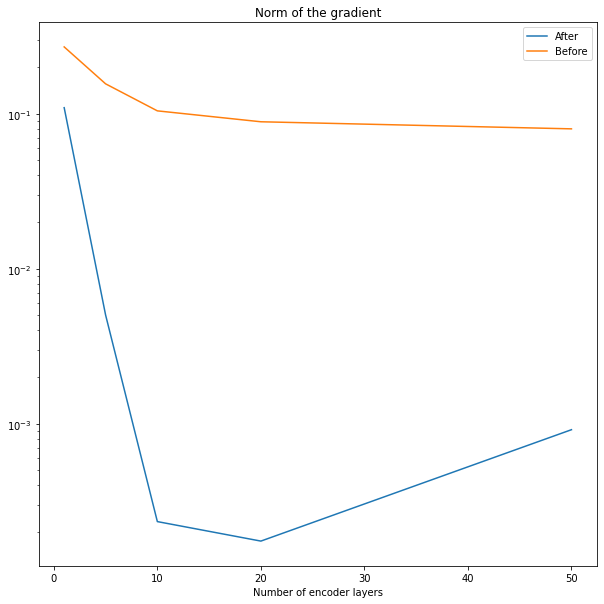

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10, 10))
ax.semilogy(list(dict_res['after'].keys()), list(dict_res['after'].values()), label='After')
ax.semilogy(list(dict_res['before'].keys()), list(dict_res['before'].values()), label='Before')
ax.set_title('Norm of the gradient')
ax.set_xlabel('Number of encoder layers')
plt.legend()

[[0.0009148306],
 [0.00017485257],
 [0.00023359958],
 [0.0050297887],
 [0.10942062]]